In [65]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import math

from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow
from keras import callbacks
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD

import warnings
warnings.filterwarnings("ignore")

ERROR! Session/line number was not unique in database. History logging moved to new session 584


In [66]:
df = pd.read_csv('./traffic.csv')

df.head()

In [ ]:
#parsing dates
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [ ]:
df = df.drop(['ID'], axis=1)

df.head()

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 01:00:00,1,13
2,2015-11-01 02:00:00,1,10
3,2015-11-01 03:00:00,1,7
4,2015-11-01 04:00:00,1,9


In [ ]:
data = df.copy()

Text(0.5, 0, 'Date')

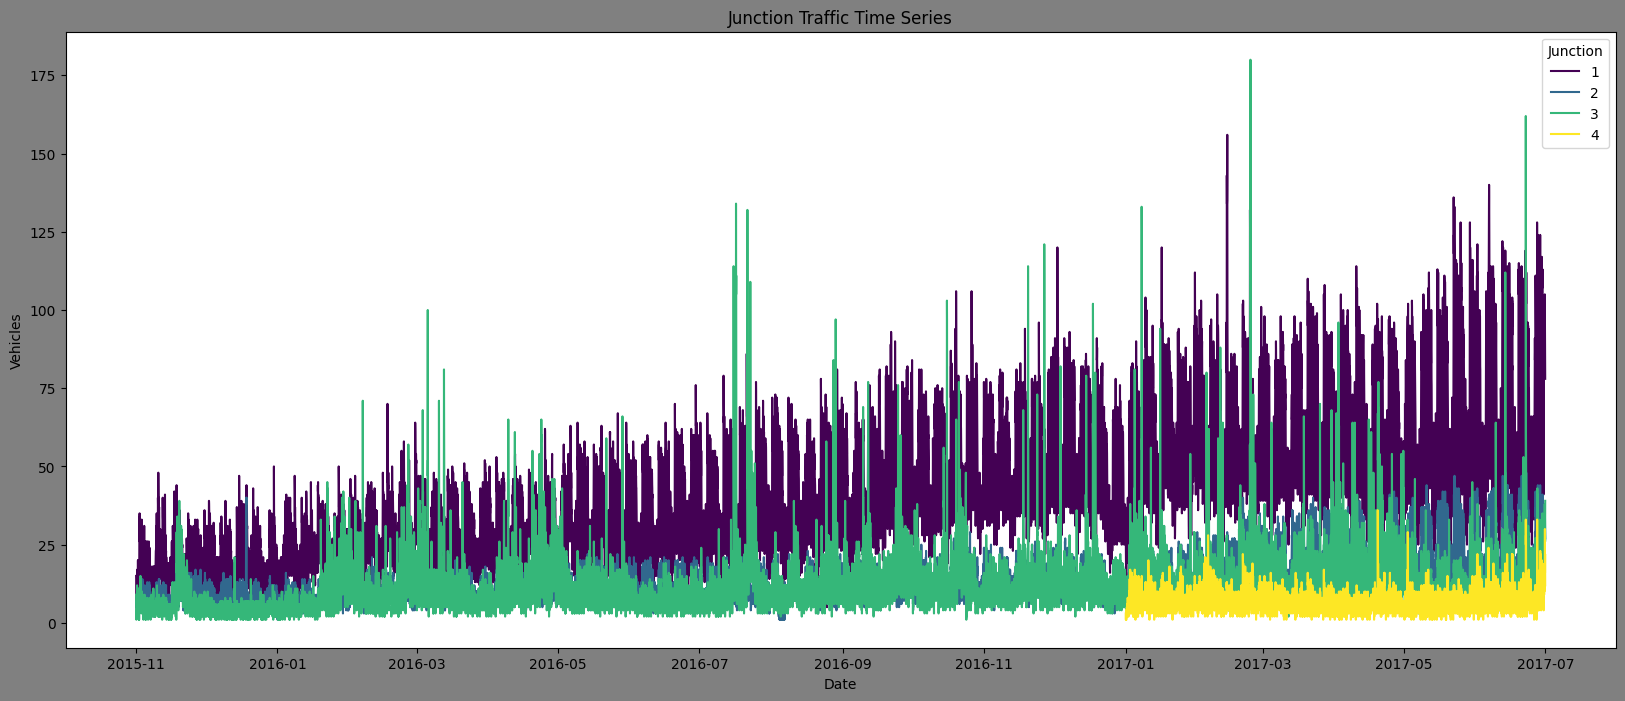

In [ ]:
plt.figure(figsize=(20,8), facecolor="#808080")
 
t_series = sns.lineplot(x=data['DateTime'], y='Vehicles', data=data, hue='Junction', palette='viridis')
t_series.set_title('Junction Traffic Time Series')
t_series.set_ylabel('Vehicles')
t_series.set_xlabel('Date')

FEATURE ENGINEERING

In [ ]:
data['Year'] = data['DateTime'].dt.year
data['Month'] = data['DateTime'].dt.month
data['Date'] = data['DateTime'].dt.day
data['Hour'] = data['DateTime'].dt.hour
data['Day'] = data.DateTime.dt.strftime("%A")

data.head()

,DateTime,Junction,Vehicles,Year,Month,Date,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


EDA

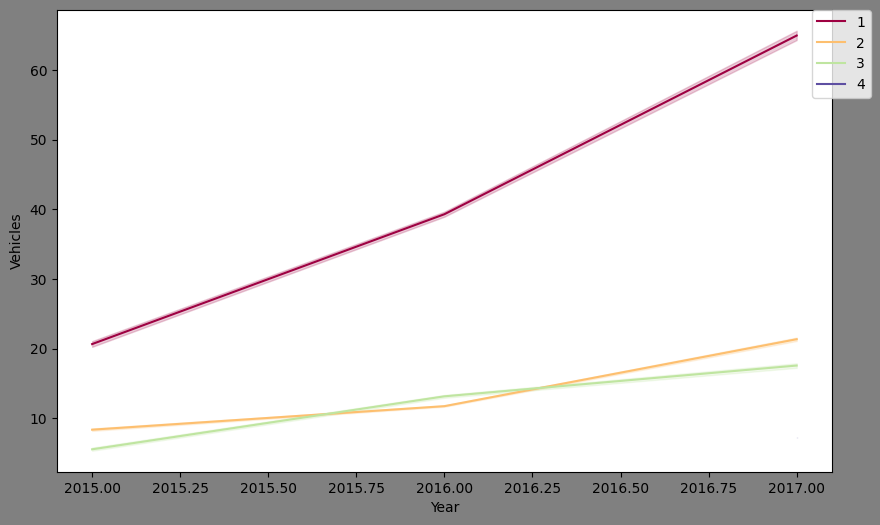

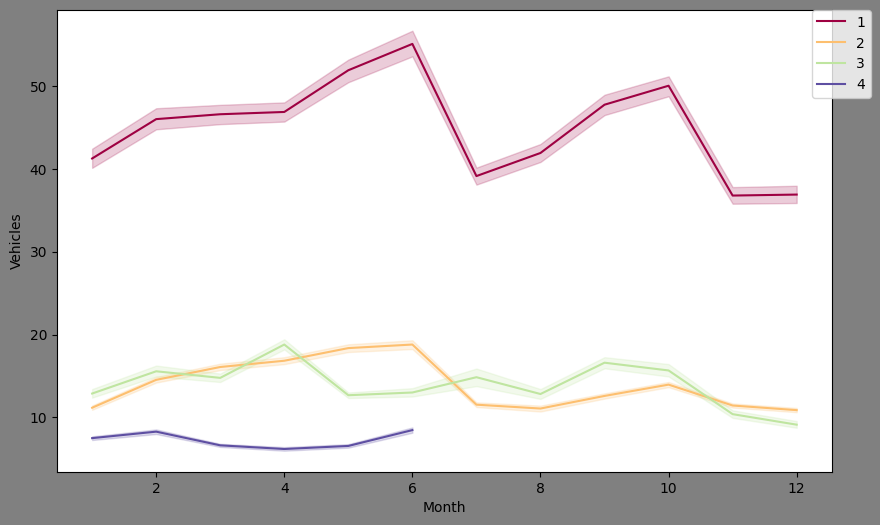

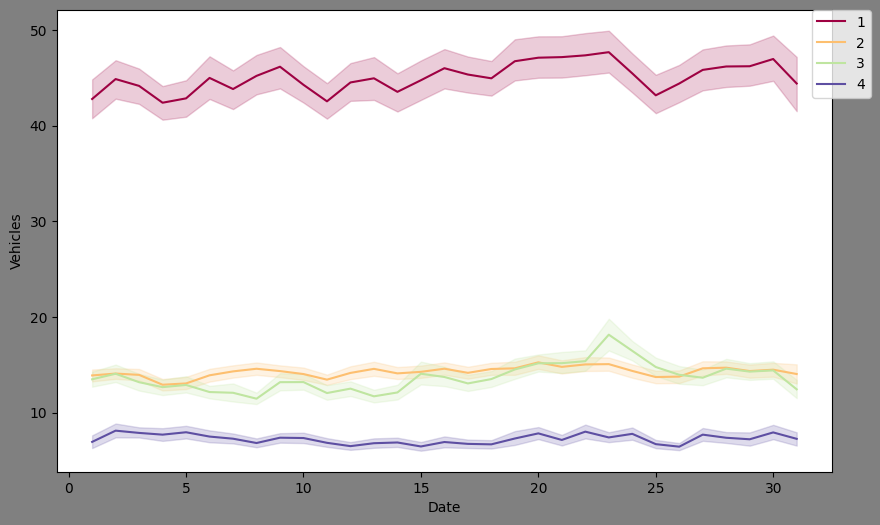

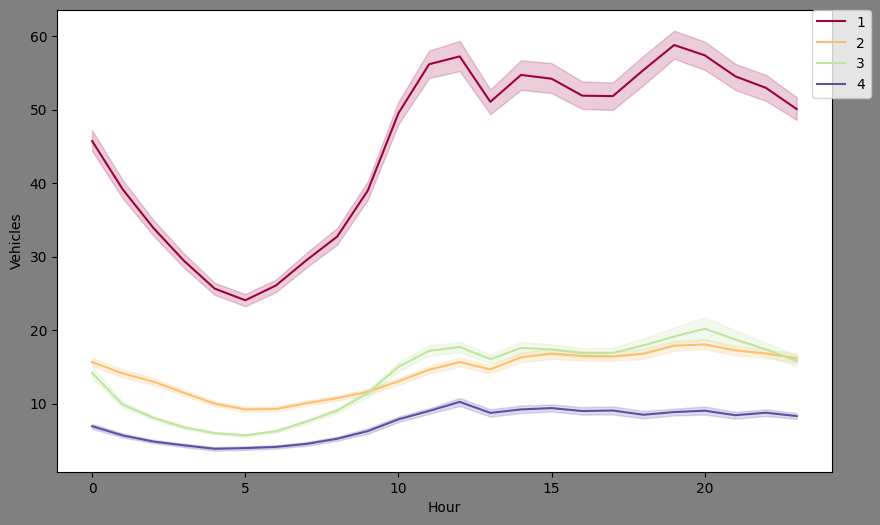

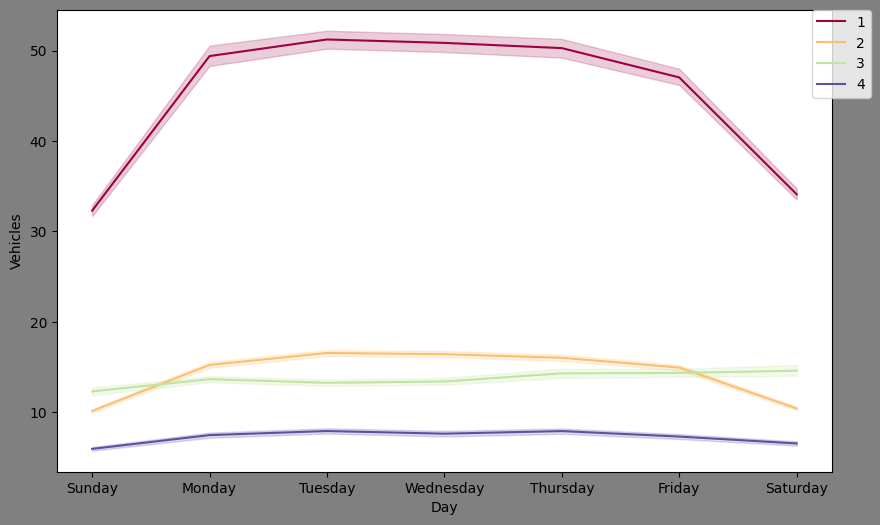

In [ ]:
n_features = ['Year', 'Month', 'Date', 'Hour', 'Day']

for i in n_features:
    plt.figure(figsize=(10,6), facecolor="#808080")
    ax = sns.lineplot(x=data[i], y='Vehicles', data=data, hue='Junction', palette='Spectral')
    
    plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

Text(0.5, 0, 'Date')

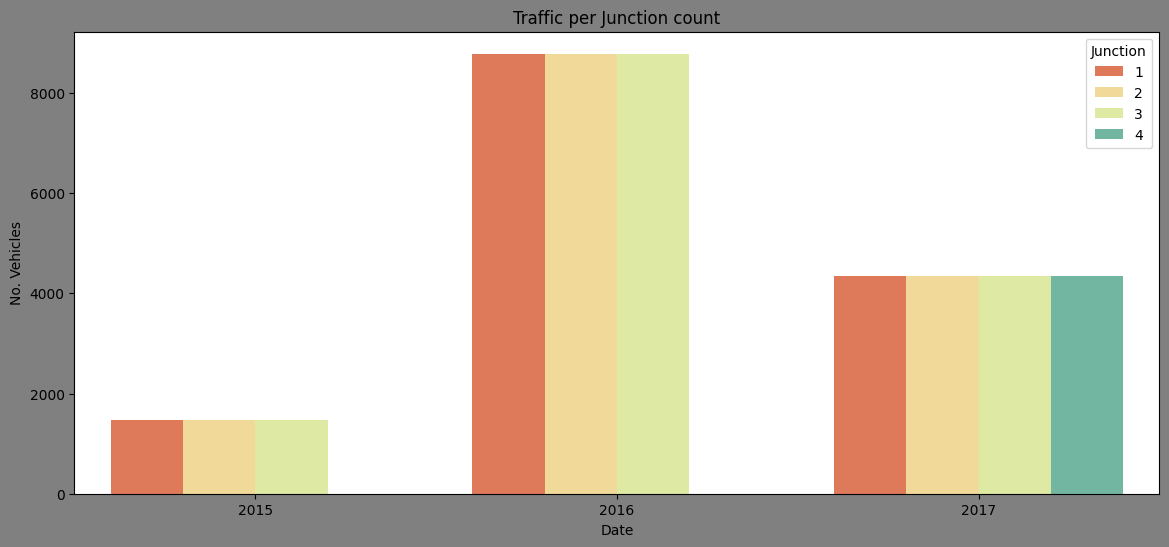

In [ ]:
plt.figure(figsize=(14, 6), facecolor='#808080')

count = sns.countplot(data=data, x=data['Year'], hue='Junction', palette='Spectral')

count.set_title('Traffic per Junction count')
count.set_ylabel('No. Vehicles')
count.set_xlabel('Date')

<AxesSubplot:>

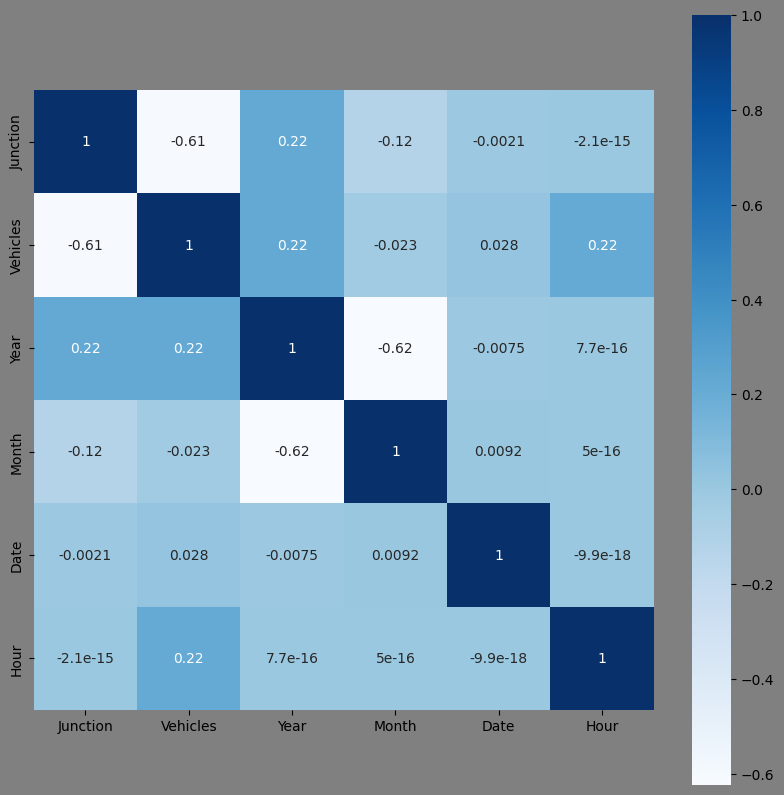

In [ ]:
corrmat = data.corr()

plt.subplots(figsize=(10,10), facecolor='#808080')
sns.heatmap(corrmat, cmap='Blues', annot=True, square=True)

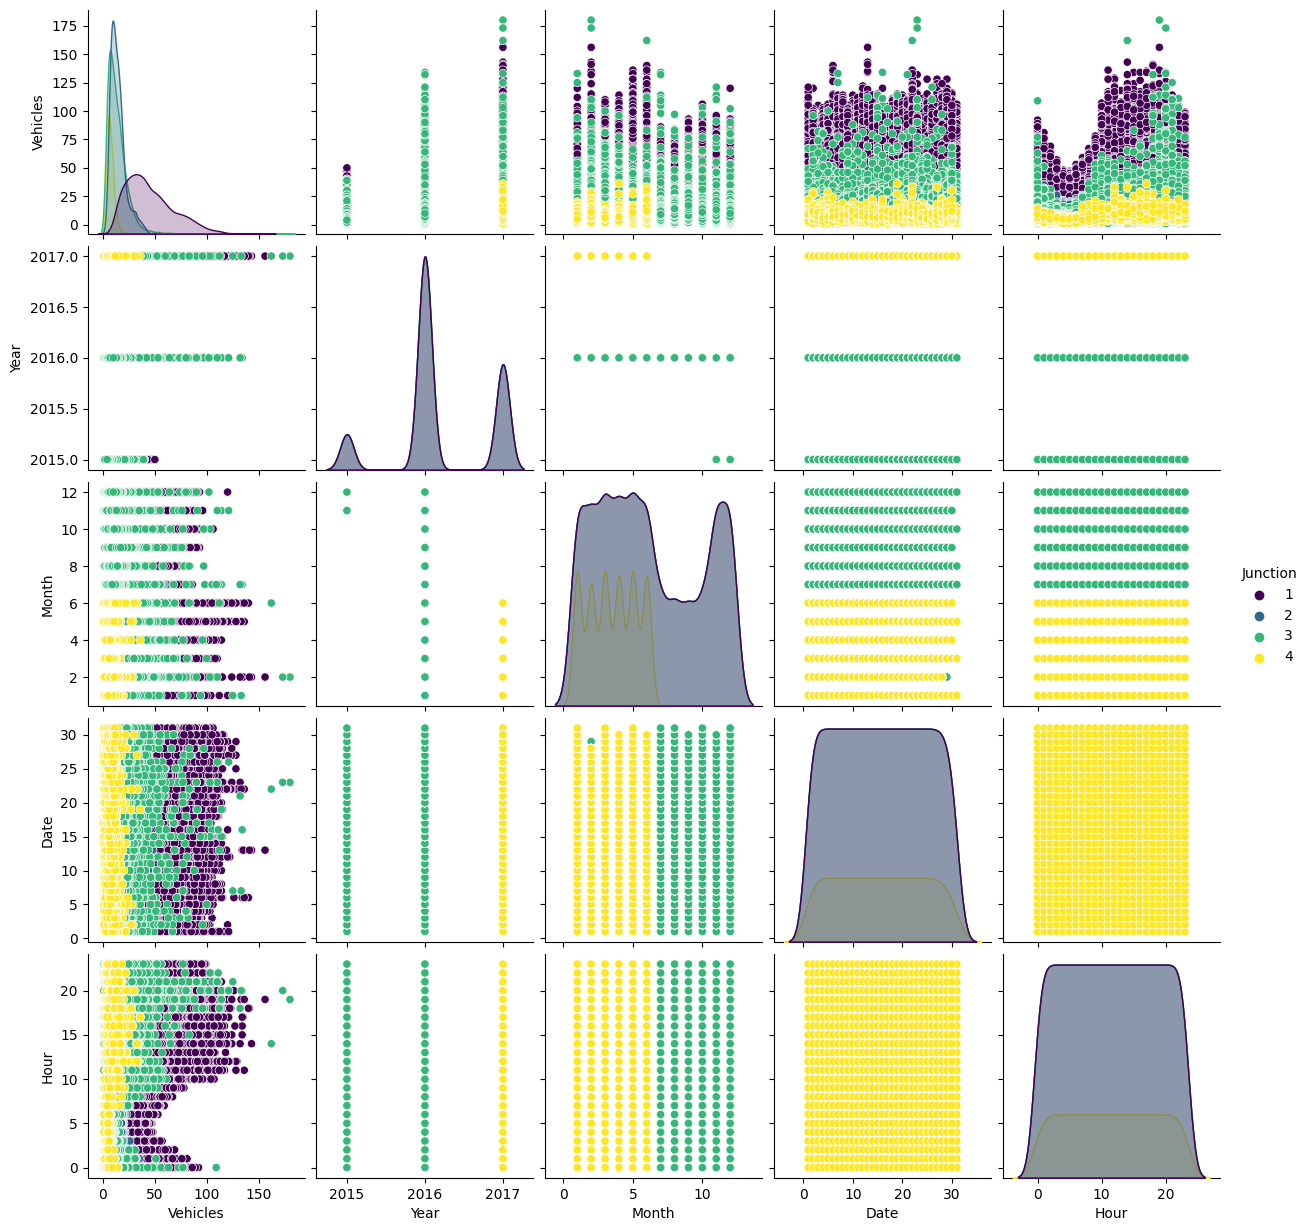

In [ ]:
sns.pairplot(data=data, hue='Junction', palette='viridis')

In [ ]:
df

,DateTime,Junction,Vehicles
0,2015-11-01 00:00:00,1,15
1,2015-11-01 01:00:00,1,13
2,2015-11-01 02:00:00,1,10
3,2015-11-01 03:00:00,1,7
4,2015-11-01 04:00:00,1,9
...,...,...,...
48115,2017-06-30 19:00:00,4,11
48116,2017-06-30 20:00:00,4,30
48117,2017-06-30 21:00:00,4,16
48118,2017-06-30 22:00:00,4,22


In [ ]:
df_j = df.pivot(columns='Junction', index="DateTime")

df_j.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

In [ ]:
df_1 = df_j[[('Vehicles', 1)]]
df_2 = df_j[[('Vehicles', 2)]]
df_3 = df_j[[('Vehicles', 3)]]
df_4 = df_j[[('Vehicles', 4)]]

df_4 = df_4.dropna()

In [ ]:
list_df = [df_1, df_2, df_3, df_4]

for i in list_df:
    i.columns = i.columns.droplevel(level=1)

    def sub_plots_4(df_1, df_2, df_3, df_4, title):
        fig, axes = plt.subplots(4, 1, figsize=(15, 8), facecolor="#808080", sharey=True)
        fig.suptitle(title)

        plot_1 = sns.lineplot(ax=axes[0], data=df_1, color='blue')
        axes[0].set(ylabel = 'Junction 1')

        plot_2 = sns.lineplot(ax=axes[1], data=df_2, color='red')
        axes[1].set(ylabel='Junction 2')

        plot_3 = sns.lineplot(ax=axes[2], data=df_3, color='purple')
        axes[2].set(ylabel='Junction 3')

        plot_4 = sns.lineplot(ax=axes[3], data=df_4, color='green')
        axes[3].set(ylabel = 'Junction 4')

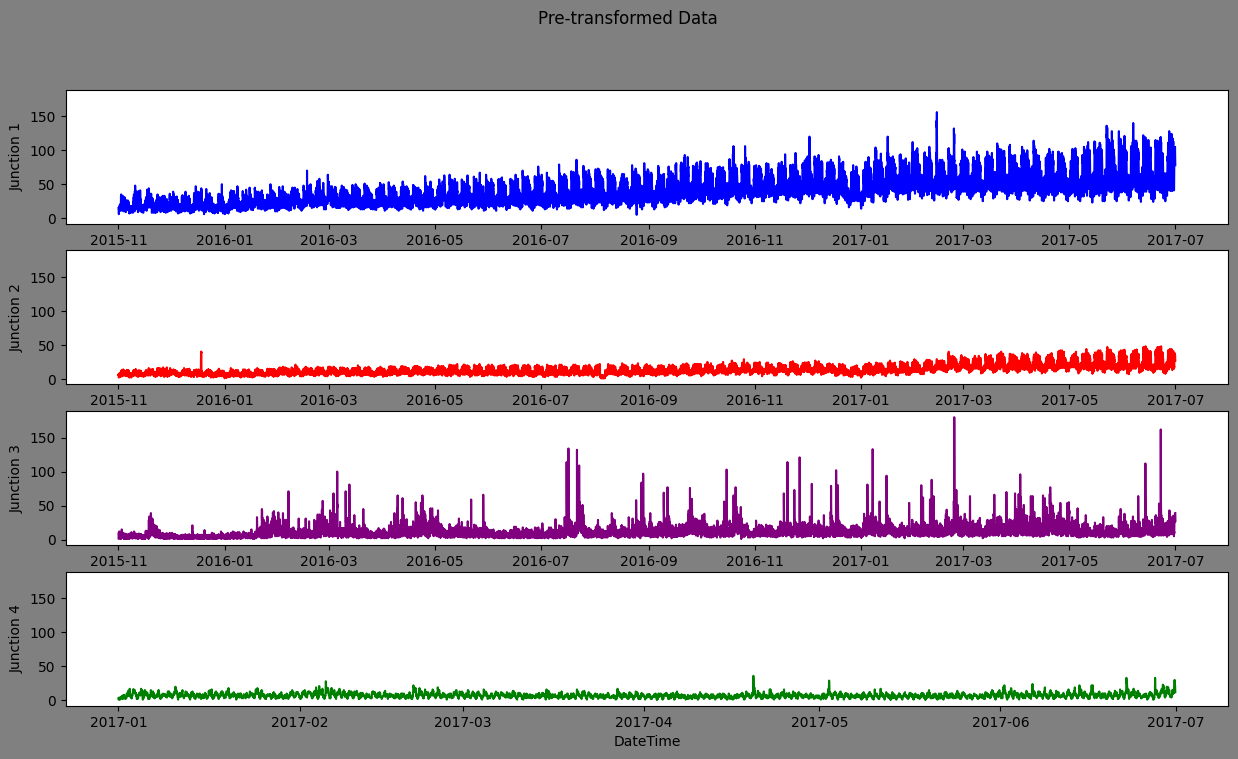

In [ ]:
sub_plots_4(df_1.Vehicles, df_2.Vehicles, df_3.Vehicles, df_4.Vehicles, 'Pre-transformed Data')

In [ ]:
#normalization
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()

    return df_normalized, average, stdev


In [ ]:
# Differencing Function
def Difference(df,col, interval):
    diff = []

    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
        
    return diff

In [ ]:
#Normalizing and Differencing to make the series stationary 
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) 
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

In [ ]:
df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) 
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

In [ ]:
df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) 
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

In [ ]:
df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) 
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

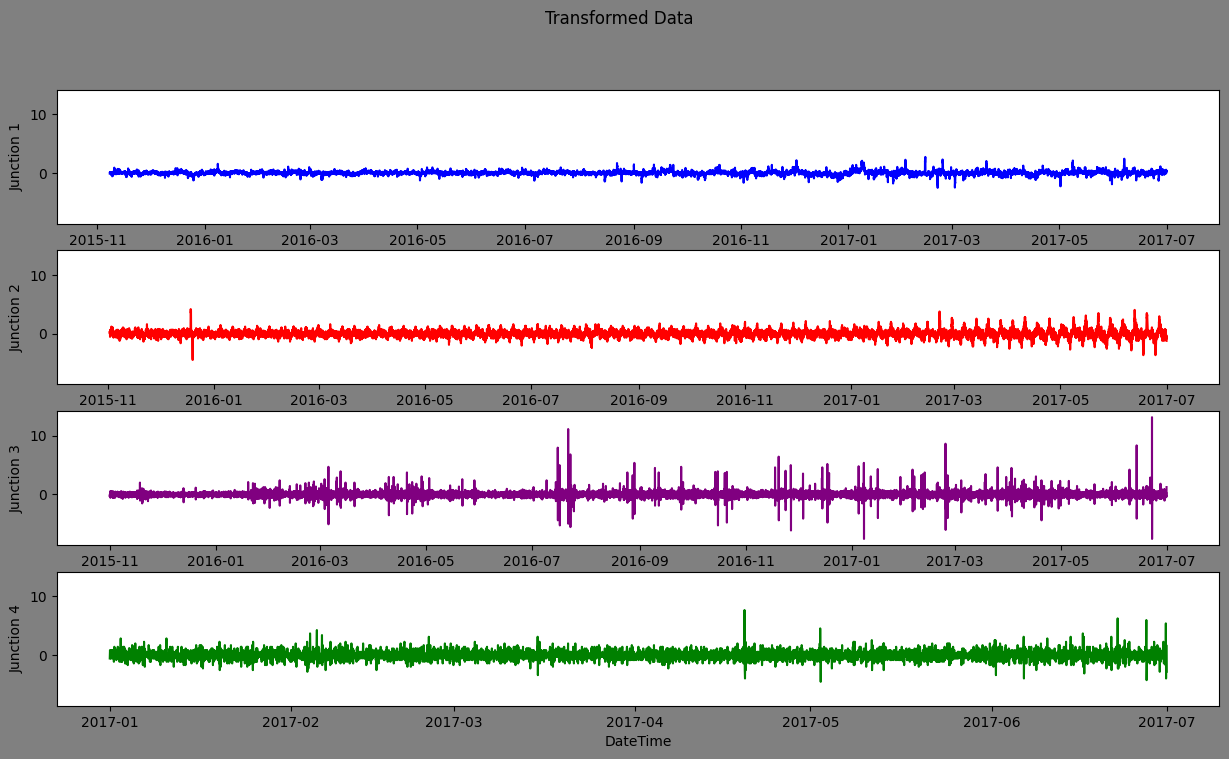

In [ ]:
sub_plots_4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Transformed Data")

In [ ]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())

    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")

    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Non-Stationary")
    else:
        print("Stationary") 

#Checking if the series is stationary
List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]] 
print("stationarity check:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

stationarity check:


ADF Statistic: -15.265303390415538
p-value: 4.7985398763952365e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


ADF Statistic: -21.795891026940016
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


ADF Statistic: -28.00175990883325
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


ADF Statistic: -17.979092563052216
p-value: 2.77878753259558e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationary


In [ ]:

df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

In [ ]:
#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test

In [ ]:
#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

In [ ]:
#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

In [ ]:
#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

In [ ]:
#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

In [ ]:
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]

KeyboardInterrupt: 

In [ ]:
#The GRU model 
#Model for the prediction
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True) 

    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    #Compiling the model
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=20, batch_size=100, callbacks=[early_stopping])

    pred_GRU= model.predict(X_Test)
    return pred_GRU


In [ ]:
#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

In [ ]:
#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [ ]:
#Predictions For First Junction
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)

Epoch 1/20
130/130 [==============================] - 293s 482ms/step - loss: 0.0736
Epoch 2/20
130/130 [==============================] - 53s 411ms/step - loss: 0.0655
Epoch 3/20
130/130 [==============================] - 56s 428ms/step - loss: 0.0631
Epoch 4/20
130/130 [==============================] - 56s 431ms/step - loss: 0.0611
Epoch 5/20
130/130 [==============================] - 51s 392ms/step - loss: 0.0597
Epoch 6/20
130/130 [==============================] - 58s 443ms/step - loss: 0.0597
Epoch 7/20
130/130 [==============================] - 55s 422ms/step - loss: 0.0577
Epoch 8/20
130/130 [==============================] - 52s 399ms/step - loss: 0.0569
Epoch 9/20
130/130 [==============================] - 54s 415ms/step - loss: 0.0552
Epoch 10/20
130/130 [==============================] - 48s 365ms/step - loss: 0.0545
Epoch 11/20
130/130 [==============================] - 45s 344ms/step - loss: 0.0546
Epoch 12/20
130/130 [==============================] - 48s 367ms/step - l

In [ ]:
#Results for J1 
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

The root mean squared error is 0.2505723272515869.


NameError: name 'colors' is not defined

<Figure size 1200x500 with 0 Axes>

In [ ]:
#Predictions For Second Junction
PredJ2 = GRU_model(X_trainJ2,y_trainJ2,X_testJ2)

In [ ]:
#Results for J2
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

In [ ]:
#Predictions For Third Junction
PredJ3 = GRU_model(X_trainJ3,y_trainJ3,X_testJ3) 

In [ ]:
#Results for J3
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,2)

In [ ]:
#Predictions For Forth Junction
PredJ4 = GRU_model(X_trainJ4,y_trainJ4,X_testJ4)

In [ ]:
#Results for J4
RMSE_J4=RMSE_Value(y_testJ4,PredJ4)
PredictionsPlot(y_testJ4,PredJ4,3)

In [ ]:
# Functions to inverse transforms and Plot comparitive plots
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    
    return inversed

In [ ]:
#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")
    fig.suptitle(title)
    
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")
    
    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

In [ ]:
# invert the differenced forecast for Junction 1 
recover1 = df_N1.Norm[-1412:-1].to_frame()
recover1["Pred"]= PredJ1

Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]

#Invert the normalizeation J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + av_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred

#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], df_1[-1412:-1],"Pridictions And Orignals For Junction 1", 0)

In [ ]:
#Invert the differenced J2
recover2 = df_N2.Norm[-1426:-1].to_frame() #len as per the diff
recover2["Pred"]= PredJ2

Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + av_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred

#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], df_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)

In [ ]:
#Invert the differenced J3
recover3 = df_N3.Norm[-1429:-1].to_frame() #len as per the diff
recover3["Pred"]= PredJ3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]

#Invert the normalizeation J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + av_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], df_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)

In [ ]:
#Invert the differenced J4
recover4 = df_N4.Norm[-404:-1].to_frame()  #len as per the testset
recover4["Pred"]= PredJ4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]

#Invert the normalizeation J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + av_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], df_4[-404:-1],"Pridictions And Orignals For Junction 4", 3)